In [ ]:
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import funciones_4 as fn4
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA

fs = 48000  

audio11, fs11 = sf.read("audio_sesion1/nicolas_01.wav")
audio21, fs21 = sf.read("audio_sesion1/soleil_01.wav")
audio31, fs31 = sf.read("audio_sesion1/cristo_01.wav")

audio12, fs12 = sf.read("audio_sesion2/nicolas_02.wav")
audio22, fs22 = sf.read("audio_sesion2/soleil_02.wav")
audio32, fs32 = sf.read("audio_sesion2/cristo_02.wav")

In [2]:
# =========================================================
# CARGA DE GRABACIÓN 1 (training)
# =========================================================
audio11 = fn4.ensure_mono(audio11)
audio21 = fn4.ensure_mono(audio21)
audio31 = fn4.ensure_mono(audio31)

min_len = min(len(audio11), len(audio21), len(audio31))
audio11, audio21, audio31 = audio11[:min_len], audio21[:min_len], audio31[:min_len]

X = np.column_stack([audio11, audio21, audio31])   # Mezcla multicanal
print("Forma mezcla (grabación 1):", X.shape)


Forma mezcla (grabación 1): (2165291, 3)


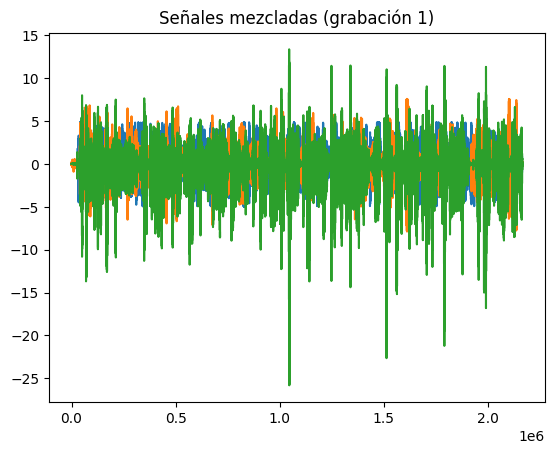

In [3]:
# =========================================================
# PREPROCESAMIENTO ICA: CENTRADO + WHITENING PCA
# =========================================================

X_centered = X - X.mean(axis=0)
pca = PCA(whiten=True)
X_white = pca.fit_transform(X_centered)
plt.figure()
plt.title("Señales mezcladas (grabación 1)")
plt.plot(X_white)
plt.show()

In [4]:
ica = FastICA(n_components=3, random_state=42)
S_est = ica.fit_transform(X_white)   # Señales separadas
W = ica.components_                  # Matriz de separación

print("Forma de las fuentes estimadas:", S_est.shape)

# Guardar señales separadas
sf.write("audio_result/source1_estimated.wav", S_est[:,0], fs)
sf.write("audio_result/source2_estimated.wav", S_est[:,1], fs)
sf.write("audio_result/source3_estimated.wav", S_est[:,2], fs)

Forma de las fuentes estimadas: (2165291, 3)


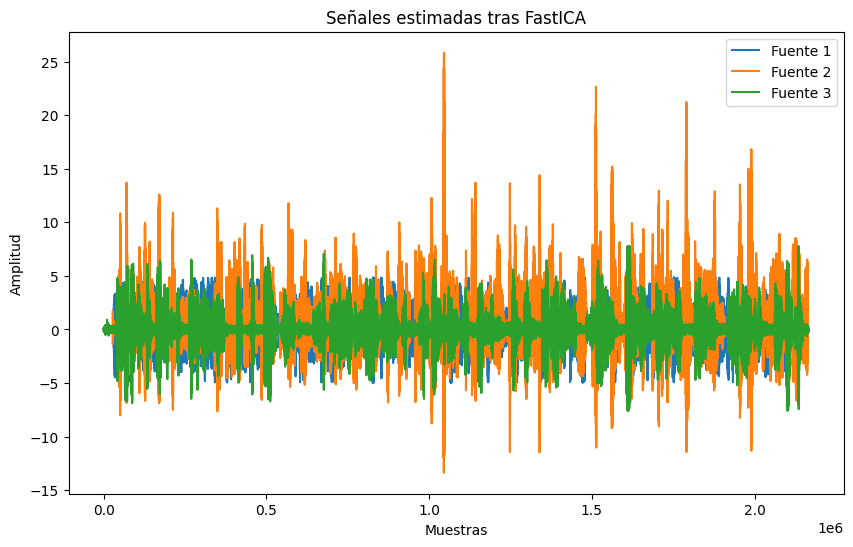

In [5]:
plt.figure(figsize=(10,6))
plt.plot(S_est)
plt.title("Señales estimadas tras FastICA")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.legend(["Fuente 1", "Fuente 2", "Fuente 3"])
plt.show()


In [6]:
# =========================================================
# MÉTRICAS CONTRA GRABACIÓN 1 (supervisión blanda)
# =========================================================

refs = [audio11, audio21, audio31]
ests = [S_est[:,0], S_est[:,1], S_est[:,2]]

print("\n===== MÉTRICAS: ENTRENAMIENTO (Grabación 01) =====")
for i in range(3):
    ref, est = fn4.match_len(refs[i], ests[i])
    print(f"\nFuente {i+1}:")
    print(" Correlación =", np.corrcoef(ref, est)[0,1])
    print(" SNR =", fn4.snr(ref, est), "dB")
    print(" SI-SDR =", fn4.sisdr(ref, est), "dB")


===== MÉTRICAS: ENTRENAMIENTO (Grabación 01) =====

Fuente 1:
 Correlación = 0.002483214570070085
 SNR = -17.698061587654795 dB
 SI-SDR = -52.16126995270869 dB

Fuente 2:
 Correlación = -0.999995437981329
 SNR = -29.000633652543378 dB
 SI-SDR = 50.126000674754266 dB

Fuente 3:
 Correlación = -0.0047291390510387854
 SNR = -16.843474978434344 dB
 SI-SDR = -46.51052389872537 dB


In [7]:

audio1_2 = fn4.ensure_mono(audio12)
audio2_2 = fn4.ensure_mono(audio22)
audio3_2 = fn4.ensure_mono(audio32)

min_len2 = min(len(audio1_2), len(audio2_2), len(audio3_2))
audio1_2, audio2_2, audio3_2 = audio1_2[:min_len2], audio2_2[:min_len2], audio3_2[:min_len2]

X2 = np.column_stack([audio1_2, audio2_2, audio3_2])
print("\nForma mezcla (grabación 2):", X2.shape)



Forma mezcla (grabación 2): (2223813, 3)


In [8]:
# =========================================================
# APLICAR MISMA MATRIZ W (NO ENTRENAR DE NUEVO)
# =========================================================

# Centrar con media de X2
X2_centered = X2 - X2.mean(axis=0)

# Whitening usando PCA ya entrenado → TRANSFORM
X2_white = pca.transform(X2_centered)

S_est2 = (W @ X2_white.T).T  # Fuentes de validación

# Guardar
sf.write("audio_result/source1_validation.wav", S_est2[:,0], fs)
sf.write("audio_result/source2_validation.wav", S_est2[:,1], fs)
sf.write("audio_result/source3_validation.wav", S_est2[:,2], fs)

In [9]:
# =========================================================
# MÉTRICAS VALIDACIÓN
# =========================================================

refs2 = [audio1_2, audio2_2, audio3_2]
ests2 = [S_est2[:,0], S_est2[:,1], S_est2[:,2]]

print("\n===== MÉTRICAS: VALIDACIÓN (Grabación 02) =====")
for i in range(3):
    ref, est = fn4.match_len(refs2[i], ests2[i])
    print(f"\nFuente {i+1}:")
    print(" Correlación =", np.corrcoef(ref, est)[0,1])
    print(" SNR =", fn4.snr(ref, est), "dB")
    print(" SI-SDR =", fn4.sisdr(ref, est), "dB")



===== MÉTRICAS: VALIDACIÓN (Grabación 02) =====

Fuente 1:
 Correlación = 0.005366498155649583
 SNR = -21.59997876459215 dB
 SI-SDR = -45.44889073701589 dB

Fuente 2:
 Correlación = -0.9999979730548704
 SNR = -29.000663224957307 dB
 SI-SDR = 53.40261676030792 dB

Fuente 3:
 Correlación = -0.0044816582116368854
 SNR = -13.047160902780426 dB
 SI-SDR = -46.97816779124845 dB
